### Argos


### Negative Binomial distribution

__Story__. We perform a series of Bernoulli trials. The number of failures, $y$, before we get $\alpha$ successes is Negative Binomially distributed. An equivalent story is that the sum of $\alpha$  independent and identically Gamma distributed variables is Negative Binomial distributed.

__Parameters__. There are two parameters: $\alpha$, the desired number of successes, and $\beta$, which is the mean of the $\alpha$ identical Gamma distributions that give the Negative Binomial. The probability of success of each Bernoulli trial is given by $\beta/(1+\beta)$

__Support__ The Negative-Binomial distribution is supported on the set of nonnegative integers.

__Probability mass function__ 

#### Import libraries

In [1]:
import json
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy import stats
from cmdstanpy import CmdStanModel

#### Generate samples from Zero Inflated Negative Binomial distribution

In [18]:
def make_pdf(n,p,theta):
    """Return a zinb probability; use numpy/scipy.stats parametrization """
    def pdf(y,n,p,theta):
        if y == 0:
            prob = 0
        elif y == 1:
            prob = theta + (1-theta) * nbinom.pmf(y-1, n, p)
        else:
            prob = (1-theta) * nbinom.pmf(y-1, n, p)  
        return prob       
    return pdf

def make_cdf(pdf):
    """Return cumulative probability function for pdf."""
    def cdf(y,n,p,theta):
        return sum(pdf(j,n,p,theta) for j in range(0,y+1))
    return cdf
                   
def find_interval(u, cdf):
    """Find y such that u falls in I_y of given cdf."""
    y = 1
    while True:
        (left, right) = (cdf(y-1,n,p,theta), cdf(y,n,p,theta))
        if left < u <= right:
            return y-1
        y += 1   
                   
def memoize(f):
    """Memoize pdf and cdf."""          
    cache = dict()
    def f_mem(y,n,p,theta):
        if y not in cache:
            cache[y] = f(y,n,p,theta)
        return cache[y]
    return f_mem                   
                   
def simulate(cdf, rng):
    """Simulate from pdf using rng::numpy.random.RandomState."""
    u = rng.uniform()
    return find_interval(u, cdf)  

In [19]:
# Usage: 

#Example 1

seed = 20
n = 0.5
p = 0.2
theta = 0.2
pdf_zinb = make_pdf(n,p,theta)
cdf_zinb = make_cdf(pdf_zinb)
rng = np.random.RandomState(seed)
print([simulate(cdf_zinb, rng) for i in range(0,100)])

# Example 2
seed = 20
n = 0.5
p = 0.2
theta = 0.2
pdf_zinb = make_pdf(n,p,theta)
cdf_zinb = make_cdf(pdf_zinb)
pdf_zinb_mem = memoize(pdf_zinb)
cdf_zinb_mem = memoize(make_cdf(pdf_zinb_mem))
rng = np.random.RandomState(seed) 
print([simulate(cdf_zinb_mem, rng) for i in range(0,100)])

[1, 5, 5, 3, 0, 1, 0, 0, 1, 0, 0, 2, 2, 4, 2, 0, 0, 2, 0, 0, 4, 7, 1, 0, 2, 0, 1, 3, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 2, 0, 2, 3, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 7, 5, 4, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 2, 3, 0, 0, 5, 0, 6, 1, 2, 0]
[1, 5, 5, 3, 0, 1, 0, 0, 1, 0, 0, 2, 2, 4, 2, 0, 0, 2, 0, 0, 4, 7, 1, 0, 2, 0, 1, 3, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 2, 0, 2, 3, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 7, 5, 4, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 2, 3, 0, 0, 5, 0, 6, 1, 2, 0]


### Class zinb

In [16]:
class zinb:

    def __init__(self,n,p,theta,seed=1):
        self.n = n
        self.p = p
        self.theta = theta
        pdf_zinb = self.__make_pdf(n,p,theta)
        cdf_zinb = self.__make_cdf(pdf_zinb)
        pdf_zinb_mem = self.__memoize(pdf_zinb)
        self.cdf_zinb_mem = self.__memoize(self.__make_cdf(pdf_zinb_mem))
        self.seed = seed
        self.rng = np.random.RandomState(self.seed) 
        
    def set_seed(self,seed=1):
        self.seed = seed
        self.rng = np.random.RandomState(self.seed)    
     
    def __make_pdf(self, n,p,theta):
        """Return a zinb probability; use numpy/scipy.stats parametrization """
        def pdf(y,n,p,theta):
            if y == 0:
                prob = 0
            elif y == 1:
                """compute p(K=0) """
                prob = theta + (1-theta) * nbinom.pmf(y-1, n, p)
            else:
                """compute p(K=k), k > 0 """
                prob = (1-theta) * nbinom.pmf(y-1, n, p)  
            return prob       
        return pdf

    def __make_cdf(self,pdf):
        """Return cumulative probability function for pdf."""
        def cdf(y,n,p,theta):
            return sum(pdf(j,n,p,theta) for j in range(0,y+1))
        return cdf
                   
    def __find_interval(self,u, cdf, n, p,theta):
        """Find y such that u falls in I_y of given cdf."""
        y = 1
        while True:
            (left, right) = (cdf(y-1,n,p,theta), cdf(y,n,p,theta))
            if left < u <= right:
                return y-1
            y += 1   
                   
    def __memoize(self,f):
        """Memoize pdf and cdf."""          
        cache = dict()
        def f_mem(y,n,p,theta):
            if y not in cache:
                cache[y] = f(y,n,p,theta)
            return cache[y]
        return f_mem               
                   
    def random(self,size=None):
        """Simulate from pdf using rng::numpy.random.RandomState."""
        
        if size == None:
            u = self.rng.uniform()
            samples = self.__find_interval(u, 
                                           self.cdf_zinb_mem,
                                           self.n,
                                           self.p,
                                            self.theta) 
        else:
            samples = []
            for s in range(0,size):
                u = self.rng.uniform(size=None) 
                samples.append(self.__find_interval(u, 
                                                    self.cdf_zinb_mem,
                                                    self.n,
                                                    self.p,
                                                    self.theta))
        
        
        return samples    
                
    
    

In [20]:
# Usage

z = zinb(n=0.5,p=0.2,theta=0.2,seed=20)
print(z.random(100))



[1, 5, 5, 3, 0, 1, 0, 0, 1, 0, 0, 2, 2, 4, 2, 0, 0, 2, 0, 0, 4, 7, 1, 0, 2, 0, 1, 3, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 2, 0, 2, 3, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 7, 5, 4, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 2, 3, 0, 0, 5, 0, 6, 1, 2, 0]


#### Class Stan model

In [21]:
class StanModel:
    def __init__(self, 
                option = 'tsc_tsc'): # stan model
             
        self.stan_file_name  = "zinb_" + option + ".stan"
        if os.path.exists("./" + self.stan_file_name):
            # specify Stan program file
            stan_file = os.path.join(self.stan_file_name)
            # instantiate the model object
            self.model = CmdStanModel(stan_file=stan_file,cpp_options={'STAN_THREADS': 'TRUE'},compile='force')
        else:
            raise ValueError('Stan file does not exist')
            
            
            

#### Class Argos

In [40]:
class Argos:
    def __init__(self,
                 sigma_mu1               = 5.0,
                 sigma_beta1             = 5.0,
                 sigma_psi1              = 0.1,
                 sigma_eta               = 0.0001,
                 sigma_zeta              = 0.0001,
                 sigma_kappa             = 0.09,
                 rho                     = 0.995,
                 To                      = 365,
                 seasonality_components  = 4,   
                 sigma                   = 5,
                 Tc                      = 365,
                 sigma_mu1_              = 5.0,
                 sigma_beta1_            = 5.0,
                 sigma_psi1_             = 0.1,
                 sigma_eta_              = 0.001,
                 sigma_zeta_             = 0.001,
                 sigma_kappa_            = 0.09,
                 rho_                    = 0.995,
                 To_                     = 365,
                 seasonality_components_ = 4,
                 sigma_                  = 5,
                 Tc_                     = 365,
                 chi_df                  = 3,
                 option                  = 'tsc_tsc'):
      
        # Count data series
        self.ys                      = pd.Series(data=[0], index=[0])

        # Data parameters       
        self.sigma_mu1               = sigma_mu1        
        self.sigma_beta1             = sigma_beta1        
        self.sigma_psi1              = sigma_psi1
        self.sigma_eta               = sigma_eta
        self.sigma_zeta              = sigma_zeta
        self.sigma_kappa             = sigma_kappa
        self.rho                     = rho
        self.To                      = To
        self.seasonality_components  = seasonality_components  
        self.sigma                   = sigma
        self.lambda_c                = 2*np.pi/Tc 
        self.sigma_mu1_              = sigma_mu1_        
        self.sigma_beta1_            = sigma_beta1_        
        self.sigma_psi1_             = sigma_psi1_  
        self.sigma_eta_              = sigma_eta_ 
        self.sigma_zeta_             = sigma_zeta_
        self.sigma_kappa_            = sigma_kappa_
        self.rho_                    = rho_
        self.To_                     = To_
        self.seasonality_components_ = seasonality_components_
        self.sigma_                  = sigma_        
        self.lambda_c_               = 2*np.pi/Tc_    
        self.chi_df                  = chi_df

        self.sigmas_gamma = []
        self.sigmas_gamma_ = []
        
        self.option = option
        
        # Optimization samples
        self.num_iter                = 100000
        
        # sampling parameters
        self.num_samples             = 20000
        
        # Stan working files
        self.json_file       = "data/output/argosfit100000tmp.json"
        self.output_dir      = "./data/tmp/"

        
    def import_data_frame(self, file_name):
              
        self.data_frame = pd.DataFrame()  
        df =  pd.read_csv(file_name)
                 
        # Add columns to the class empty data frame from input df     
            
        if 'Counts' in df:  # 'y' will be in training data
            self.data_frame.insert(0, "y", pd.to_numeric(df['Counts'], downcast='integer') )
            if np.isinf(self.data_frame['y'].values).any():
                raise ValueError('Found infinity in column "Counts".')
        else:        
            raise ValueError('Columnn "Counts" does not exist.')
            
        if 'Time-index' in df:  # 'y' will be in training data
            self.data_frame.insert(1,"time", pd.to_numeric(df['Time-index'], downcast='float')) 
            if np.isinf(self.data_frame['time'].values).any():
                raise ValueError('Found infinity in column "Time-index".')
        else:        
            raise ValueError('Columnn "Time-index" does not exist.')
                
        if 'Index' in df:  # 'y' will be in training data
            self.data_frame.insert(2,"index", pd.to_numeric(df['Index']))
            if np.isinf(self.data_frame['index'].values).any():
                raise ValueError('Found infinity in column "Index".')
        else:        
            raise ValueError('Columnn "Index" does not exist.')
        
        ys = self.data_frame["y"]
        self.ys = pd.Series(data =  ys.to_numpy(), index = self.data_frame["time"])    
        return self.data_frame      
    
    def set_option(self, option):
        self.option = option
    
    def set_data(self,
                 sigma_mu1               = 5.0,
                 sigma_beta1             = 5.0,
                 sigma_psi1              = 0.1,
                 sigma_eta               = 0.0001,
                 sigma_zeta              = 0.0001,
                 sigma_kappa             = 0.09,
                 rho                     = 0.995,
                 To                      = 365,
                 seasonality_components  = 4, 
                 sigma                   = 5,
                 Tc                      = 365,
                 sigma_mu1_              = 5.0,
                 sigma_beta1_            = 5.0,
                 sigma_psi1_             = 0.1,
                 sigma_eta_              = 0.001,
                 sigma_zeta_             = 0.001,
                 sigma_kappa_            = 0.09,
                 rho_                    = 0.995,
                 To_                     = 365,
                 seasonality_components_ = 4,
                 sigma_                  = 5,
                 Tc_                     = 365,
                 chi_df                  = 3):
      
        # Data parameters       
        self.sigma_mu1               = sigma_mu1        
        self.sigma_beta1             = sigma_beta1        
        self.sigma_psi1              = sigma_psi1
        self.sigma_eta               = sigma_eta
        self.sigma_zeta              = sigma_zeta
        self.sigma_kappa             = sigma_kappa
        self.rho                     = rho
        self.To                      = To
        self.seasonality_components  = seasonality_components  
        self.sigma                   = sigma
        self.lambda_c                = 2*np.pi/Tc
        self.sigma_mu1_              = sigma_mu1_        
        self.sigma_beta1_            = sigma_beta1_        
        self.sigma_psi1_             = sigma_psi1_  
        self.sigma_eta_              = sigma_eta_ 
        self.sigma_zeta_             = sigma_zeta_
        self.sigma_kappa_            = sigma_kappa_
        self.rho_                    = rho_
        self.To_                     = To_
        self.seasonality_components_ = seasonality_components_
        self.sigma_                  = sigma_
        self.lambda_c_               = 2*np.pi/Tc_     
        self.chi_df                  = chi_df 
        
        
        self.sigmas_gamma = self.sigma * np.ones(self.seasonality_components*2) # weakly informative prior
        self.sigmas_gamma_ = self.sigma_ * np.ones(self.seasonality_components_*2) # weakly informative prior
 
   
    def get_parameters(self, fit):
        if self.option == "tsc_tsc":
            parameters = self.__get_parameters_tsc_tsc(fit)
        elif self.option == "ts_ts":
            parameters = self.__get_parameters_ts_ts(fit)
        else:    
            raise ValueError('Model is not available:' + self.option) 
        return parameters 
    

    def __get_parameters_tsc_tsc(self, fit):
        
        mu      = getattr(fit, 'mu')
        beta    = getattr(fit, 'beta')
        psi     = getattr(fit, 'psi')
        psi_k   = getattr(fit, 'psi_k')
        gammas  = getattr(fit, 'gammas')
        mu_     = getattr(fit, 'mu_')
        beta_   = getattr(fit, 'beta_')
        psi_    = getattr(fit, 'psi_')
        psi_k_  = getattr(fit, 'psi_k_')
        gammas_ = getattr(fit, 'gammas_')
        phi     = getattr(fit, 'phi')

        parameters = {
            "mu"      : mu,
            "beta"    : beta,
            "psi"     : psi,
            "psi_k"   : psi_k,
            "gammas"  : gammas,
            "mu_"     : mu_,
            "beta_"   : beta_,
            "psi_"    : psi_,
            "psi_k_"  : psi_k_,
            "gammas_" : gammas_,
            "phi"     : phi        
        }    
        return parameters   

    def __get_parameters_ts_ts(self, fit):
        
        mu      = getattr(fit, 'mu')
        beta    = getattr(fit, 'beta')
        gammas  = getattr(fit, 'gammas')
        mu_     = getattr(fit, 'mu_')
        beta_   = getattr(fit, 'beta_')
        gammas_ = getattr(fit, 'gammas_')
        phi     = getattr(fit, 'phi')

        parameters = {
            "mu"      : mu,
            "beta"    : beta,
            "gammas"  : gammas,
            "mu_"     : mu_,
            "beta_"   : beta_,
            "gammas_" : gammas_,
            "phi"     : phi 
        }    
        return parameters     
    
       
    def __compute_fourier_data(self, t, num_coefficients, To):
        fourier_data = np.zeros(2*num_coefficients)
        for n in range(0,num_coefficients):
            fourier_data[n] = np.cos(2*math.pi*(n+1)*t/To)
            fourier_data[n+num_coefficients] = np.sin(2*math.pi*(n+1)*t/To)
        return fourier_data 
    
    def __compute_seasonality_parameters(self, ys, seasonality_components, sigma, To):
        X = []
        for index in ys.index:
            tmp = self.__compute_fourier_data(index, seasonality_components ,To)
            X.append(tmp.tolist())
        sigmas_gamma = np.ones(2*seasonality_components) * sigma
        parameters = {
            "X"            : X,
            "sigmas_gamma" : sigmas_gamma.tolist()
        }             
        return parameters
    
    def serialize(self, ys):
        if self.option == "tsc_tsc":
            data = self.__serielize_tsc_tsc(ys)
        elif self.option == "ts_ts":
            data = self.__serielize_ts_ts(ys)    
        else:
            raise ValueError('Model is not available:' + self.option) 
        return data 
    
                     
    def __serielize_tsc_tsc(self, ys): 
                               
        sp  = self.__compute_seasonality_parameters(ys, self.seasonality_components, self.sigma, self.To) 
        sp_ = self.__compute_seasonality_parameters(ys, self.seasonality_components_, self.sigma_, self.To_) 
                        
        data = {
            "T"                             : len(ys.to_numpy()),
            "sigma_mu1"                     : self.sigma_mu1,
            "sigma_beta1"                   : self.sigma_beta1,
            "sigma_psi1"                    : self.sigma_psi1,
            "sigma_eta"                     : self.sigma_eta,
            "sigma_zeta"                    : self.sigma_zeta,
            "sigma_kappa"                   : self.sigma_kappa,
            "rho"                           : self.rho,
            "lambda_c"                      : self.lambda_c,
            "S"                             : len(sp["X"][0]),
            "X"                             : sp["X"],
            "sigmas_gamma"                  : sp["sigmas_gamma"],
            "sigma_mu1_"                    : self.sigma_mu1_,
            "sigma_beta1_"                  : self.sigma_beta1_,
            "sigma_psi1_"                   : self.sigma_psi1_,
            "sigma_eta_"                    : self.sigma_eta_,
            "sigma_zeta_"                   : self.sigma_zeta_,
            "sigma_kappa_"                  : self.sigma_kappa_,
            "rho_"                          : self.rho_,
            "lambda_c_"                     : self.lambda_c_,
            "S_"                            : len(sp_["X"][0]),
            "X_"                            : sp_["X"],            
            "sigmas_gamma_"                 : sp_["sigmas_gamma"],
            "chi_df"                        : self.chi_df,
            "y"                             : ys.to_numpy().tolist(),  
        }  
        
        with open(self.json_file, "w") as outfile:
            json.dump(data, outfile)
        
        return data   
    
    def __serielize_ts_ts(self, ys): 
                               
        sp  = self.__compute_seasonality_parameters(ys, self.seasonality_components, self.sigma, self.To) 
        sp_ = self.__compute_seasonality_parameters(ys, self.seasonality_components_, self.sigma_, self.To_) 
                        
        data = {
            "T"                             : len(ys.to_numpy()),
            "sigma_mu1"                     : self.sigma_mu1,
            "sigma_beta1"                   : self.sigma_beta1,
            "sigma_psi1"                    : self.sigma_psi1,
            "sigma_eta"                     : self.sigma_eta,
            "sigma_zeta"                    : self.sigma_zeta,
            "sigma_kappa"                   : self.sigma_kappa,
            "rho"                           : self.rho,
            "lambda_c"                      : self.lambda_c,
            "S"                             : len(sp["X"][0]),
            "X"                             : sp["X"],
            "sigmas_gamma"                  : sp["sigmas_gamma"],
            "sigma_mu1_"                    : self.sigma_mu1_,
            "sigma_beta1_"                  : self.sigma_beta1_,
            "sigma_psi1_"                   : self.sigma_psi1_,
            "sigma_eta_"                    : self.sigma_eta_,
            "sigma_zeta_"                   : self.sigma_zeta_,
            "sigma_kappa_"                  : self.sigma_kappa_,
            "rho_"                          : self.rho_,
            "lambda_c_"                     : self.lambda_c_,
            "S_"                            : len(sp_["X"][0]),
            "X_"                            : sp_["X"],            
            "sigmas_gamma_"                 : sp_["sigmas_gamma"],
            "chi_df"                        : self.chi_df,
            "y"                             : ys.to_numpy().tolist(),  
        }  
        
        with open(self.json_file, "w") as outfile:
            json.dump(data, outfile)
        
        return data   
    
    def set_iter(self,num_iter):
        self.num_iter = num_iter
    
    def fit(self, stan_model):
        if self.option == "tsc_tsc":
            fit = self.__fit_tsc_tsc(stan_model)
        elif self.option == "ts_ts":
            fit = self.__fit_ts_ts(stan_model)
        else: 
            raise ValueError('Model is not available:' + self.option) 
        return fit    
        
    def __fit_tsc_tsc(self, stan_model):
        data_file = os.path.join(self.json_file)
        fit = stan_model.model.optimize(data=data_file, output_dir=self.output_dir, iter= self.num_iter)
        return fit
    
    def __fit_ts_ts(self, stan_model):
        data_file = os.path.join(self.json_file)
        fit = stan_model.model.optimize(data=data_file, output_dir=self.output_dir, iter= self.num_iter)
        return fit    
    
    
    def slice_time_series(self, ys, prop, days):
        
        PROP = prop
        DAYS = days

        time_periods = len(ys.index)
        proportion = int(time_periods * PROP)
        proportion_days = proportion - proportion % DAYS
        remaining_days = time_periods - proportion_days
        periods = int((remaining_days - remaining_days % DAYS)/DAYS)
        num_validation_periods = periods  # + 1 no se por que puse esta suma???? 
        end = proportion_days
         
        start = 1
        start_index = []
        end_index = []
        for i in range(0,periods+1):
            start_index.append(start-1)
            end_index.append(end-1)
            end += DAYS
            start += DAYS       
            
            
        par = {
            "start_index"              : start_index,
            "end_index"                : end_index, 
            "time_periods"             : time_periods,
            "proportion"               : proportion,
            "proportion_days"          : proportion_days,
            "remaining_days"           : remaining_days,
            "periods"                  : periods,
            "num_validation_periods"   : num_validation_periods,
            "days"                     : days
        }    
          
        slices = []
        for index in range(0,num_validation_periods):
            
            si = start_index[index]
            ei = end_index[index]
            yw = ys[ys.index[si]:ys.index[ei-1]]
            yt = ys[ys.index[ei + 1]: ys.index[ei + 1 + days-1]]
            data = {
                "yw"   : yw,
                "yt"   : yt,
            }         
            slices.append(data)   
            
            
        return par, slices
    
    def set_num_samples(self,num_samples):
        self.num_samples = num_samples
        
    def sample(self, yw, yt, stan_data, stan_parameters):
        if self.option == "tsc_tsc":
            data = self.sample_tsc_tsc(yw, yt, stan_data, stan_parameters)
        elif self.option == "ts_ts":
            data = self.sample_ts_ts(yw, yt, stan_data, stan_parameters)  
        else:
            raise ValueError('Model is not available:' + self.option) 
        return data     
        
        
    
    def sample_tsc_tsc(self, yw, yt, stan_data, stan_parameters): 
            
        # Retrieve MLE parameters
        # Negative binomial
        mu        = stan_parameters["mu"]
        beta      = stan_parameters["beta"]
        gammas    = stan_parameters["gammas"]
        psi       = stan_parameters["psi"]
        psi_k     = stan_parameters["psi_k"]
        
        # Bernoulli
        mu_       = stan_parameters["mu_"]
        beta_     = stan_parameters["beta_"]
        gammas_   = stan_parameters["gammas_"]
        psi_      = stan_parameters["psi_"]
        psi_k_    = stan_parameters["psi_k_"]  
        phi       = stan_parameters["phi"]
        
        # Retrieve data parameters
        sigma_eta      = self.sigma_eta 
        sigma_zeta     = self.sigma_zeta
        sigma_kappa    = self.sigma_kappa
        sigmas_gamma   = self.sigmas_gamma
        rho            = self.rho
        chi_df         = self.chi_df
        lambda_c       = self.lambda_c
        sigma_eta_     = self.sigma_eta_ 
        sigma_zeta_    = self.sigma_zeta_
        sigma_kappa_   = self.sigma_kappa_
        sigmas_gamma_  = self.sigmas_gamma_
        lambda_c_      = self.lambda_c_
        rho_           = self.rho_
        
        # Compute X matrix
        sp  = self.__compute_seasonality_parameters(yt, self.seasonality_components, self.sigma, self.To)
        sp_ = self.__compute_seasonality_parameters(yt, self.seasonality_components_, self.sigma_, self.To_)   
    
        X  = np.array(sp["X"])
        X_ = np.array(sp_["X"]) 
        

        c = np.mean(yw)
        C = np.mean(np.abs(yw - c))
        R = np.sqrt(np.mean((yw - c)**2))

        
        DAYS = len(yt)

        st_all    = []
        st_all_   = []
        psi_all   = []
        psi_all_  = []
        phi_all   = []
        theta_all = []
        state_all = []
        y_hat_all = []
        mae_all   = []
        rmae_all  = []
        rmse_all  = []
        
        progress = 0
        for sample in range(0,self.num_samples):
            
            # Negative binomial 
            st         = np.zeros(DAYS)
            mu_hat     = np.zeros(DAYS)
            beta_hat   = np.zeros(DAYS)
            psi_hat    = np.zeros(DAYS)
            psi_k_hat  = np.zeros(DAYS)
            phi        = np.zeros(DAYS)
            
            # Bernoulli
            st_        = np.zeros(DAYS)
            mu_hat_    = np.zeros(DAYS)
            beta_hat_  = np.zeros(DAYS)
            psi_hat_   = np.zeros(DAYS)
            psi_k_hat_ = np.zeros(DAYS)
            theta      = np.zeros(DAYS)
            
            # Prediction
            y_hat = np.zeros(DAYS) 
            
            # Compute sample from mixture and the corresponding error 
            ind = 0
            for index in range(0, DAYS): 
                if index == 0:
                    # Negative binomial
                    beta_hat[ind]   = np.random.normal(beta[-1], sigma_zeta)
                    mu_hat[ind]     = np.random.normal(mu[-1] + beta[-1], sigma_eta)
                    psi_hat[ind]    = np.random.normal(rho*( psi[-1] * np.cos(lambda_c) + psi_k[-1] * np.sin(lambda_c)), sigma_kappa);
                    psi_k_hat[ind]  = np.random.normal(rho*(-psi[-1] * np.sin(lambda_c) + psi_k[-1] * np.cos(lambda_c)), sigma_kappa);  
 
                    # Bernoulli
                    beta_hat_[ind]  = np.random.normal(beta_[-1], sigma_zeta_)
                    mu_hat_[ind]    = np.random.normal(mu_[-1] + beta_[-1], sigma_eta_)
                    psi_hat_[ind]   = np.random.normal(rho_*( psi_[-1] * np.cos(lambda_c_) + psi_k_[-1] * np.sin(lambda_c_)), sigma_kappa_);
                    psi_k_hat_[ind] = np.random.normal(rho_*(-psi_[-1] * np.sin(lambda_c_) + psi_k_[-1] * np.cos(lambda_c_)), sigma_kappa_);  
                    
                else:
                    # Negative binomial
                    beta_hat[ind]   = np.random.normal(beta_hat[ind-1], sigma_zeta)
                    mu_hat[ind]     = np.random.normal(mu_hat[ind-1] + beta_hat[ind-1], sigma_eta)
                    psi_hat[ind]    = np.random.normal(rho*( psi_hat[ind-1] * np.cos(lambda_c) + psi_k_hat[ind-1] * np.sin(lambda_c)), sigma_kappa);
                    psi_k_hat[ind]  = np.random.normal(rho*(-psi_hat[ind-1] * np.sin(lambda_c) + psi_k_hat[ind-1] * np.cos(lambda_c)), sigma_kappa);  

                    # Brenoulli
                    beta_hat_[ind]  = np.random.normal(beta_hat_[ind-1], sigma_zeta_)
                    mu_hat_[ind]    = np.random.normal(mu_hat_[ind-1] + beta_hat_[ind-1], sigma_eta_)
                    psi_hat_[ind]   = np.random.normal(rho_*( psi_hat_[ind-1] * np.cos(lambda_c_) + psi_k_hat_[ind-1] * np.sin(lambda_c_)), sigma_kappa_);
                    psi_k_hat_[ind] = np.random.normal(rho_*(-psi_hat_[ind-1] * np.sin(lambda_c_) + psi_k_hat_[ind-1] * np.cos(lambda_c_)), sigma_kappa_);  
            
                # Negative binomial
                st[ind]    = mu_hat[ind] + np.matmul(X[ind,:], gammas) + psi_hat[ind]
                phi[ind]   = np.random.chisquare(chi_df) 
                # Bernoulli    
                st_[ind]   = mu_hat_[ind] + np.matmul(X_[ind,:],gammas_) + psi_hat_[ind]
                theta[ind] = np.exp(st_[ind])/(1+np.exp(st_[ind]))
                
                # Update counter
                ind += 1
                

            #    Generative model:    
            #    Suppose that for each observation, there are two possible cases. 
            #    Suppose that if case 1 occurs, the count is zero. However, 
            #    if case 2 occurs, counts (including zeros) are generated according to 
            #    the negative binomial model. Suppose that case 1 occurs with probability 
            #    π and case 2 occurs with probability 1 - π.
                
            state = []
            ind = 0
            for index in range(0,DAYS):                   
                N = phi[ind] # n = alpha = phi
                P = phi[ind]/(np.exp(st[ind])+phi[ind]) # beta/(1+beta)= phi/(mu+phi)
                z = zinb(n=N,p=P,theta=theta[ind],seed=4)
                y_hat[ind]= z.random()
                ind += 1
                
                # Compute the probability that y = 0
                #A = phi[ind]
                #B = phi[ind]/np.exp(st[ind])
                #tmp = nbinom.pmf(0,A,B/(1+B))
                #prob  = theta[ind] + (1-theta[ind])*tmp
        
                #if np.random.rand() < prob:
                #    state.append(0)
                #    y_hat[ind] = 0
                #else:  
                #    state.append(1)
                #    y_hat[ind] = np.random.negative_binomial(A,B/(1+B),size=None)
                
                #ind += 1
            
            state_all.append(state)
            y_hat_all.append(y_hat)
            st_all.append(st)
            st_all_.append(st_)
            phi_all.append(phi)
            theta_all.append(theta)
            psi_all.append(psi_hat)
            psi_all_.append(psi_hat_)
            mae = np.mean(np.abs(y_hat - yt))
            mae_all.append(mae)
            rmae = mae/C
            rmae_all.append(rmae)
            rmse = np.sqrt(np.mean((y_hat - yt)**2))/R  
            rmse_all.append(rmse)
            
        samples_data = {
            "yw"         : yw,
            "yt"         : yt,  # last one  
            "phi_all"    : phi_all,
            "y_hat_all"  : y_hat_all,
            "theta_all"  : theta_all,
            "state_all"  : state_all,
            "st_all"     : st_all,
            "st_all_"    : st_all_, 
            "psi_all"    : psi_all,
            "psi_all_"   : psi_all_,
            "X"          : X,
            "X_"         : X_,
            "mae_all"    : mae_all,
            "rmae_all"   : rmae_all,
            "rmse_all"   : rmse_all            
        }    
        return samples_data

    def sample_ts_ts(self, yw, yt, stan_data, stan_parameters): 
            
        # Retrieve MLE parameters
        # Negative binomial
        mu        = stan_parameters["mu"]
        beta      = stan_parameters["beta"]
        gammas    = stan_parameters["gammas"]

        
        # Bernoulli
        mu_       = stan_parameters["mu_"]
        beta_     = stan_parameters["beta_"]
        gammas_   = stan_parameters["gammas_"]
        

        
        # Retrieve data parameters
        sigma_eta      = self.sigma_eta 
        sigma_zeta     = self.sigma_zeta
        sigma_kappa    = self.sigma_kappa
        sigmas_gamma   = self.sigmas_gamma
        rho            = self.rho
        chi_df         = self.chi_df
        lambda_c       = self.lambda_c
        sigma_eta_     = self.sigma_eta_ 
        sigma_zeta_    = self.sigma_zeta_
        sigma_kappa_   = self.sigma_kappa_
        sigmas_gamma_  = self.sigmas_gamma_
        lambda_c_      = self.lambda_c_
        rho_           = self.rho_
        
        # Compute X matrix
        sp  = self.__compute_seasonality_parameters(yt, self.seasonality_components, self.sigma, self.To)
        sp_ = self.__compute_seasonality_parameters(yt, self.seasonality_components_, self.sigma_, self.To_)   
    
        X  = np.array(sp["X"])
        X_ = np.array(sp_["X"]) 
        

        c = np.mean(yw)
        C = np.mean(np.abs(yw - c))
        R = np.sqrt(np.mean((yw - c)**2))

        
        DAYS = len(yt)

        st_all    = []
        st_all_   = []
        phi_all   = []
        theta_all = []
        state_all = []
        y_hat_all = []
        mae_all   = []
        rmae_all  = []
        rmse_all  = []
        
        progress = 0
        for sample in range(0,self.num_samples):
            
            # Negative binomial 
            st         = np.zeros(DAYS)
            mu_hat     = np.zeros(DAYS)
            beta_hat   = np.zeros(DAYS)
            psi_hat    = np.zeros(DAYS)
            psi_k_hat  = np.zeros(DAYS)
            phi        = np.zeros(DAYS)
            
            # Bernoulli
            st_        = np.zeros(DAYS)
            mu_hat_    = np.zeros(DAYS)
            beta_hat_  = np.zeros(DAYS)
            psi_hat_   = np.zeros(DAYS)
            psi_k_hat_ = np.zeros(DAYS)
            theta      = np.zeros(DAYS)
            
            # Prediction
            y_hat = np.zeros(DAYS) 
            
            # Compute sample from mixture and the corresponding error 
            ind = 0
            for index in range(0, DAYS): 
                if index == 0:
                    # Negative binomial
                    beta_hat[ind]   = np.random.normal(beta[-1], sigma_zeta)
                    mu_hat[ind]     = np.random.normal(mu[-1] + beta[-1], sigma_eta)
 
                    # Bernoulli
                    beta_hat_[ind]  = np.random.normal(beta_[-1], sigma_zeta_)
                    mu_hat_[ind]    = np.random.normal(mu_[-1] + beta_[-1], sigma_eta_)
                    
                else:
                    # Negative binomial
                    beta_hat[ind]   = np.random.normal(beta_hat[ind-1], sigma_zeta)
                    mu_hat[ind]     = np.random.normal(mu_hat[ind-1] + beta_hat[ind-1], sigma_eta)

                    # Brenoulli
                    beta_hat_[ind]  = np.random.normal(beta_hat_[ind-1], sigma_zeta_)
                    mu_hat_[ind]    = np.random.normal(mu_hat_[ind-1] + beta_hat_[ind-1], sigma_eta_)
            
                # Negative binomial
                st[ind]    = mu_hat[ind] + np.matmul(X[ind,:], gammas) 
                phi[ind]   = np.random.chisquare(chi_df) 
                # Bernoulli    
                st_[ind]   = mu_hat_[ind] + np.matmul(X_[ind,:],gammas_) 
                theta[ind] = np.exp(st_[ind])/(1+np.exp(st_[ind]))
                
                # Update counter
                ind += 1
                

            #    Generative model:    
            #    Suppose that for each observation, there are two possible cases. 
            #    Suppose that if case 1 occurs, the count is zero. However, 
            #    if case 2 occurs, counts (including zeros) are generated according to 
            #    the negative binomial model. Suppose that case 1 occurs with probability 
            #    π and case 2 occurs with probability 1 - π.
                
            state = []
            ind = 0
            for index in range(0,DAYS):                   
                N = phi[ind] # n = alpha = phi
                P = phi[ind]/(np.exp(st[ind])+phi[ind]) # beta/(1+beta)= phi/(mu+phi)
                z = zinb(n=N,p=P,theta=theta[ind],seed=20)
                y_hat[ind]= z.random()
                ind += 1
                            
            state_all.append(state)
            y_hat_all.append(y_hat)
            st_all.append(st)
            st_all_.append(st_)
            phi_all.append(phi)
            theta_all.append(theta)
            mae = np.mean(np.abs(y_hat - yt))
            mae_all.append(mae)
            rmae = mae/C
            rmae_all.append(rmae)
            rmse = np.sqrt(np.mean((y_hat - yt)**2))   #/R
            rmse_all.append(rmse)
            
        samples_data = {
            "yw"         : yw,
            "yt"         : yt,  # last one  
            "phi_all"    : phi_all,
            "y_hat_all"  : y_hat_all,
            "theta_all"  : theta_all,
            "state_all"  : state_all,
            "st_all"     : st_all,
            "st_all_"    : st_all_, 
            "X"          : X,
            "X_"         : X_,
            "mae_all"    : mae_all,
            "rmae_all"   : rmae_all,
            "rmse_all"   : rmse_all            
        }    
        return samples_data
    
    
               

In [28]:
stan_model_tsc_tsc = StanModel('tsc_tsc')
stan_model_ts_ts = StanModel('ts_ts')


17:13:50 - cmdstanpy - INFO - compiling stan file /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_tsc_tsc.stan to exe file /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_tsc_tsc
17:14:07 - cmdstanpy - INFO - compiled model executable: /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_tsc_tsc
17:14:07 - cmdstanpy - INFO - compiling stan file /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_ts_ts.stan to exe file /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_ts_ts
17:14:17 - cmdstanpy - INFO - compiled model executable: /Users/salvadorruizcorrea/Projects/Argos Panoptes/Argos/zinb_ts_ts


start_index: [0, 56, 112, 168, 224, 280, 336, 392, 448, 504, 560, 616]
end_index: [1175, 1231, 1287, 1343, 1399, 1455, 1511, 1567, 1623, 1679, 1735, 1791]
time_periods: 1825
proportion: 1186
proportion_days: 1176
ramaining_days: 649
periods: 11
num_validation_periods: 11


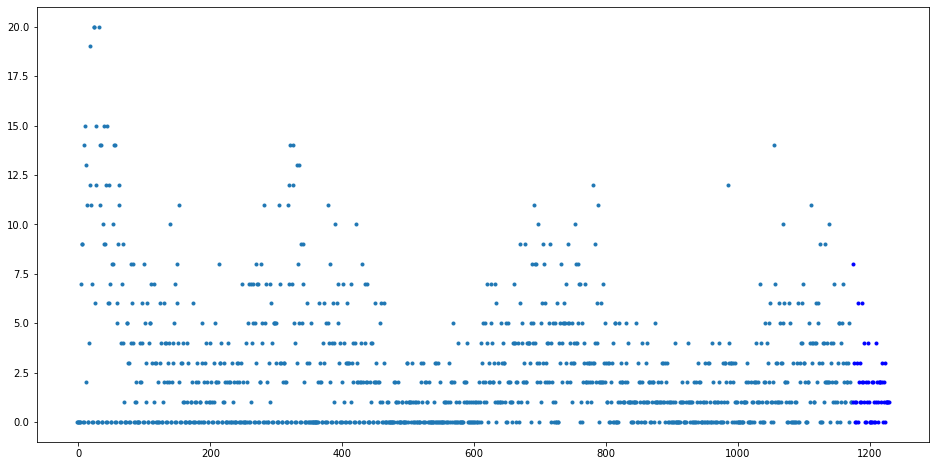

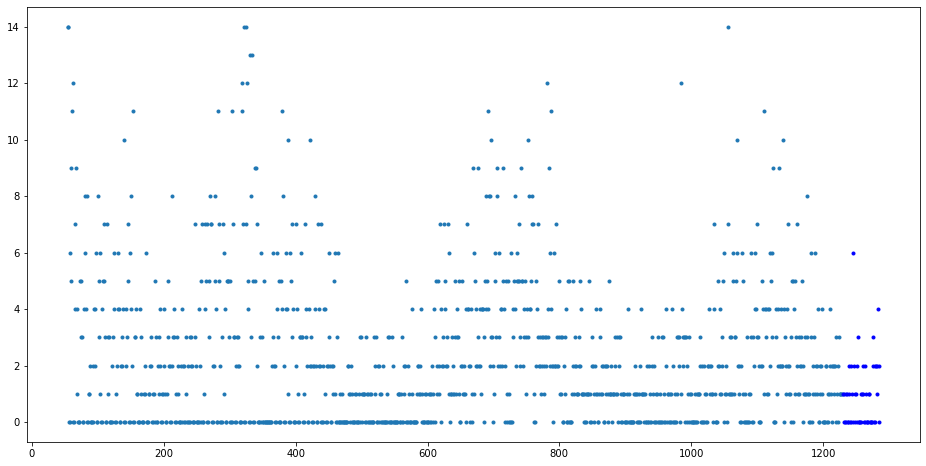

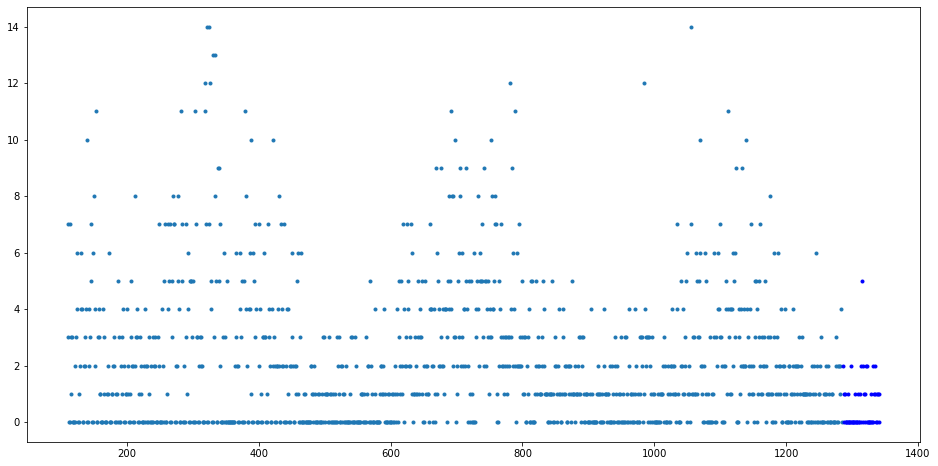

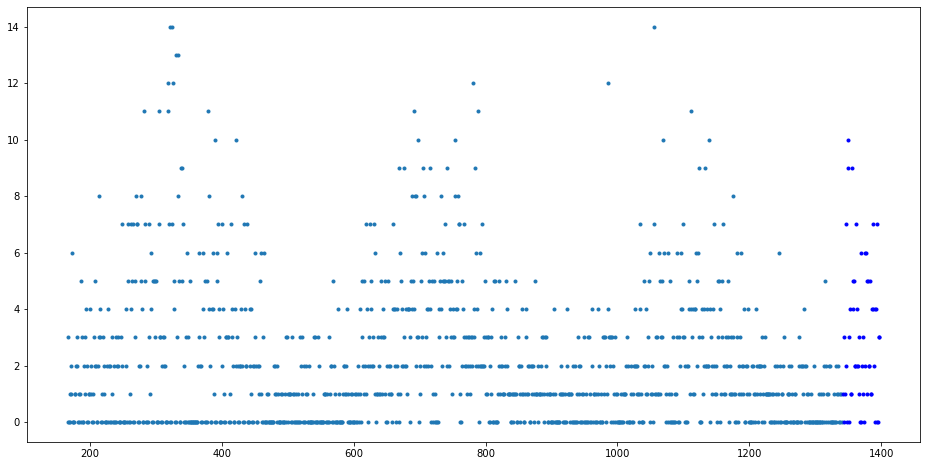

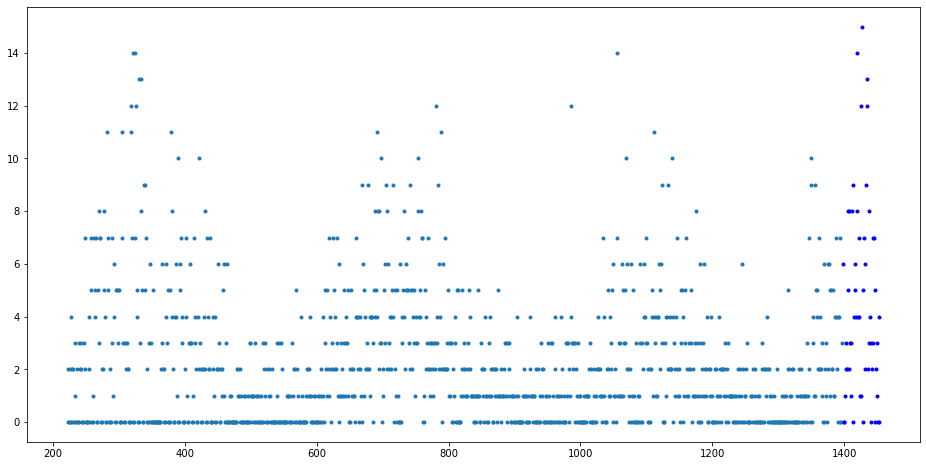

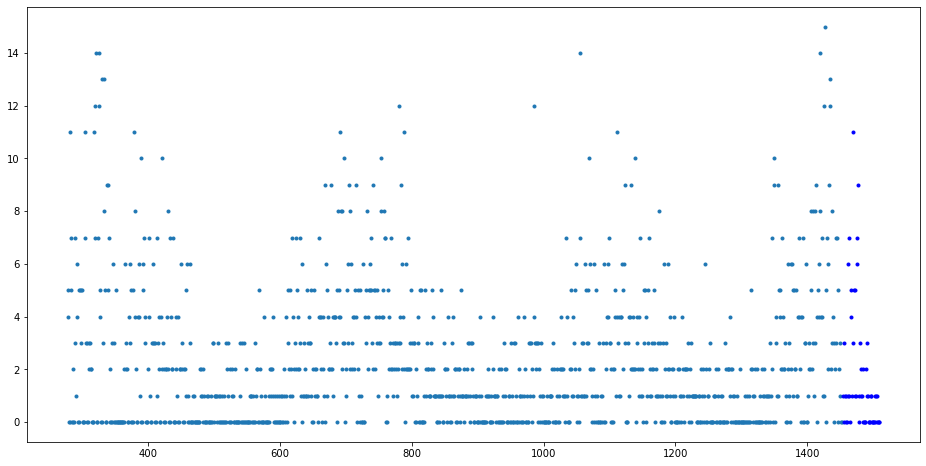

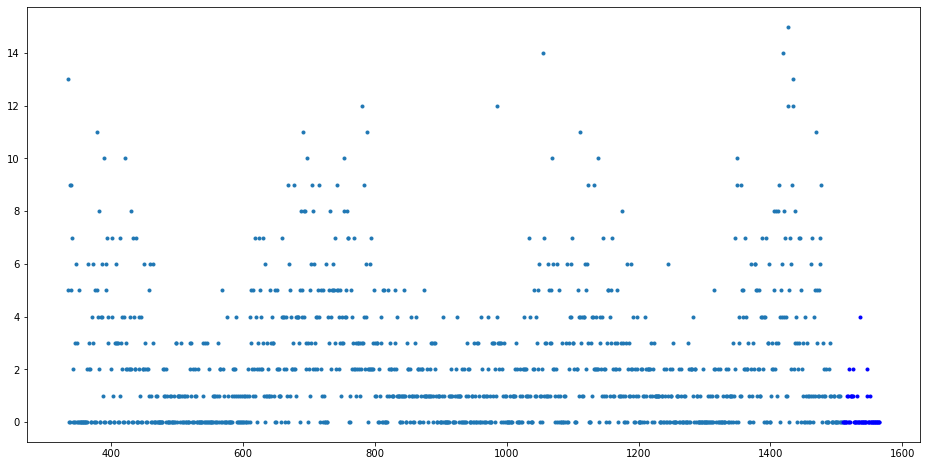

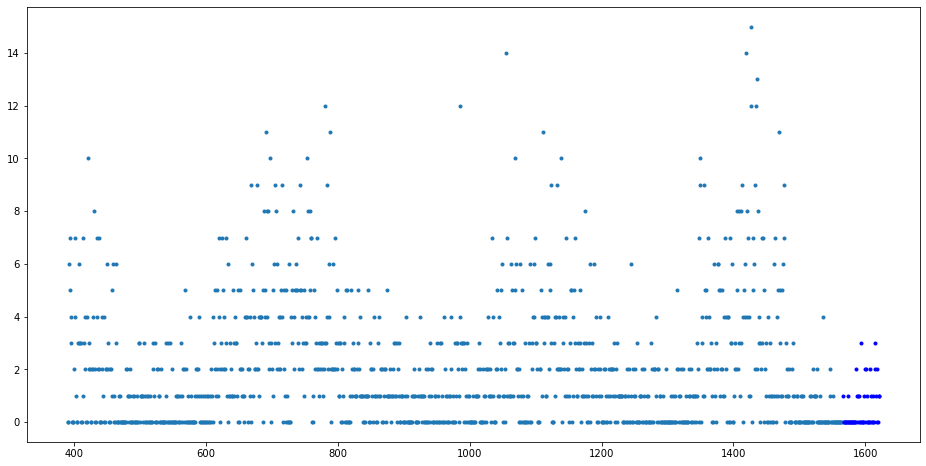

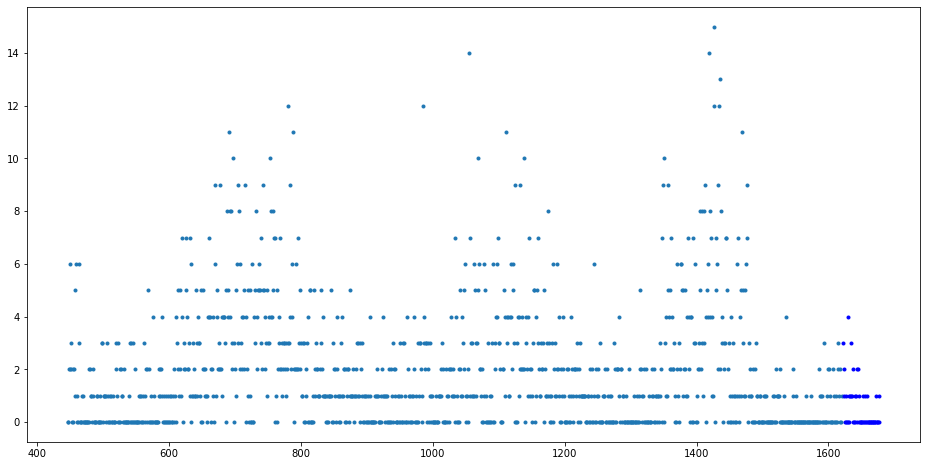

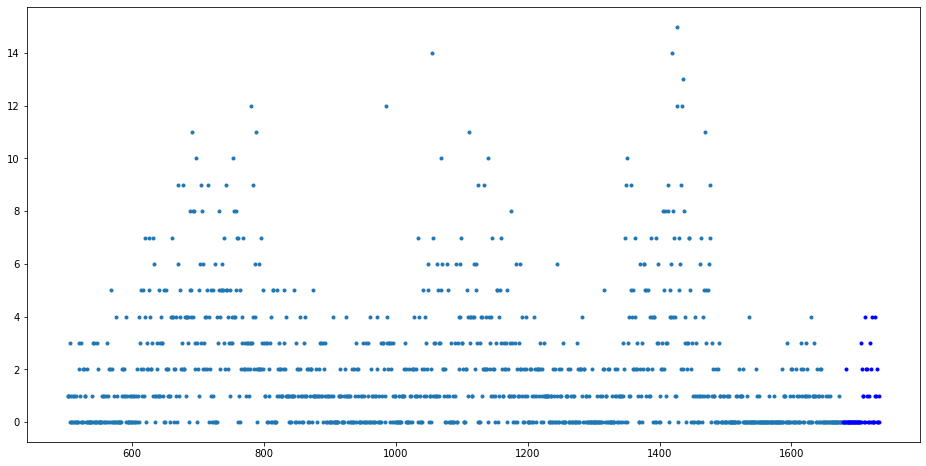

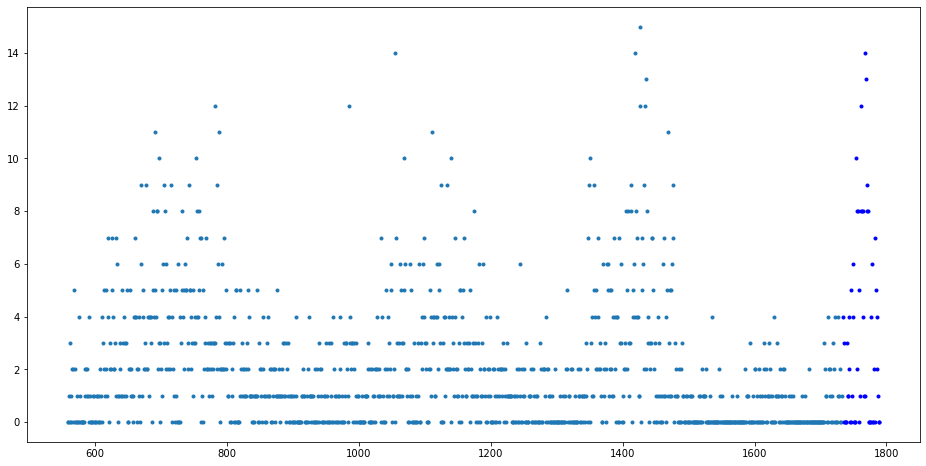

In [83]:
DAYS = 56

argos = Argos()
data_frame = argos.import_data_frame(file_name='data/output/todos_Jb_data_frame.csv')

slices_parameters, slices = argos.slice_time_series(argos.ys, prop=0.65, days=DAYS)
print("start_index:",            slices_parameters["start_index"])
print("end_index:",              slices_parameters["end_index"])
print("time_periods:",           slices_parameters["time_periods"])
print("proportion:",             slices_parameters["proportion"])
print("proportion_days:",        slices_parameters["proportion_days"])
print("ramaining_days:",         slices_parameters["remaining_days"])
print("periods:",                slices_parameters["periods"])
print("num_validation_periods:", slices_parameters["num_validation_periods"])

for slice_ in slices:
    plt.figure(figsize=(16, 8)) 
    plt.plot(slice_["yw"],'.')
    plt.plot(slice_["yt"],'b.')
    plt.show()
 

In [81]:
argos.set_option('tsc_tsc')
argos.set_iter(50000)
argos.set_num_samples(2000)


rmae = []

for slice_ in slices:
    yw = slice_["yw"]
    yt = slice_["yt"]
    argos.set_data(sigma_mu1               = 5.0,
                   sigma_beta1             = 5.0,
                   sigma_psi1              = 0.1,
                   sigma_eta               = 0.0002,
                   sigma_zeta              = 0.0002,
                   sigma_kappa             = 0.09,
                   rho                     = 0.997,
                   To                      = 365,
                   seasonality_components  = 10, 
                   sigma                   = 5,
                   Tc                      = 365,
                   sigma_mu1_              = 5.0,
                   sigma_beta1_            = 5.0,
                   sigma_psi1_             = 0.9, 
                   sigma_eta_              = 0.001, #.001
                   sigma_zeta_             = 0.001, #.001
                   sigma_kappa_            = 0.09,  
                   rho_                    = 0.995,
                   To_                     = 365,
                   seasonality_components_ = 3,
                   sigma_                  = 5,
                   Tc_                     = 365,
                   chi_df                  = 3)
       
    stan_data       = argos.serialize(yw)
    stan_fit        = argos.fit(stan_model=stan_model_tsc_tsc)
    stan_parameters = argos.get_parameters(stan_fit)
    
    
    mu     = np.array(stan_parameters["mu"])
    X      = np.array(stan_data["X"])
    gammas = np.array(stan_parameters["gammas"])
    psi    = np.array(stan_parameters["psi"])

    plt.figure(figsize=(16, 8))
    plt.plot(argos.ys,'.')
    tmp = np.exp( mu + np.matmul(X,gammas) + psi)
    #tmp = np.exp( mu + np.matmul(X,gammas))
    plt.plot(tmp)
    plt.show()
    
    samples_data = argos.sample(yw, yt, stan_data, stan_parameters)
    
    st_all     = samples_data["st_all"]
    st_all_    = samples_data["st_all_"]    
    mae_all    = samples_data["mae_all"] 
    rmae_all   = samples_data["rmae_all"]     
    rmse_all   = samples_data["rmse_all"]
    y_hat_all  = samples_data["y_hat_all"]
    theta_all  = samples_data["theta_all"]
    phi        = samples_data["phi_all"]    
    
    
    print("rRMSE = ", np.mean(np.mean(rmse_all,axis=0)))
    print("MAE = ",   np.mean(np.mean(mae_all,axis=0)))
    print("rMAE= ",   np.mean(np.mean(rmae_all,axis=0)))
        
    rmae.append(np.mean(np.mean(rmae_all,axis=0)))
    
    MU_ = np.mean(np.exp(st_all_), axis=0)
    MU = np.mean(np.exp(st_all), axis=0)
    THETA = np.mean(theta_all,axis=0)
    EY = (1-THETA) * MU  
    my = np.mean(y_hat_all,axis=0)
    stdy = np.std(y_hat_all,axis=0)
    #VARY = EY * (1+MU *(THETA + 1/np.array(phi)))
    #STDY = np.sqrt(VARY)    
      
    plt.figure(figsize=(16, 8)) 
    plt.stem(yt.to_numpy())
    plt.plot(MU_ ,'g')
    #plt.plot(EY + STDY,'g')
    plt.show()    
        
    plt.figure(figsize=(16, 8)) 
    plt.stem(yt.to_numpy())
    plt.plot(EY ,'g')
    #plt.plot(EY + STDY,'g')
    plt.show()

    plt.figure(figsize=(16, 8)) 
    plt.stem(yt.to_numpy())
    plt.plot(EY ,'g')
    plt.plot(my ,'r')
    plt.plot(my + stdy ,'r')
    plt.show()  
    
    s3 = (yt - my - stdy )/(my+stdy) 
    
    plt.stem(range(0,len(s3)),s3)        
    plt.grid()
    plt.show()  
    
    
    plt.figure(figsize=(16, 8)) 
    markerline2, stemlines, _  = plt.stem(np.linspace(1,DAYS,DAYS), yt)
    markerline1, stemlines, _  = plt.stem(np.linspace(1,DAYS,DAYS), np.mean(y_hat_all, axis=0)) 
    markerline3, stemlines, _  = plt.stem(np.linspace(1,DAYS,DAYS), np.mean(y_hat_all, axis=0) + np.std(y_hat_all, axis=0)) 
        
    plt.setp(markerline2, 'markerfacecolor', 'r')
    plt.setp(markerline1, 'markerfacecolor', 'b') 
    plt.setp(markerline3, 'markerfacecolor', 'g')  
    plt.show()
            
    plt.figure(figsize=(16, 8))  
    plt.stem(np.linspace(1,DAYS,DAYS), yt)
    plt.plot(np.exp(np.mean(st_all_,axis=0)),'b')
    plt.show()
        
    plt.figure(figsize=(16, 8))  
    plt.stem(np.linspace(1,DAYS,DAYS), yt)
    plt.plot(np.mean(theta_all,axis=0),'b')
    plt.show()     
        
    y_hat_all_p = np.percentile(y_hat_all,q=[50,75,95],axis=0)   
    a = np.mean(samples_data["y_hat_all"],axis=0)
    b = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[0]
    c = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[1]
    d = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[2]
    
    plt.plot(b,color = '#0072B2')
    plt.plot(c,color = '#0072B2')
    plt.plot(d,color = '#0072B2')
    plt.plot(a,'r')
    plt.plot(a + stdy,'r')    
    plt.stem(yt.to_numpy())
    plt.fill_between(np.linspace(0,DAYS-1,DAYS),b, c,color = '#0072B2', alpha=0.6)
    plt.fill_between(np.linspace(0,DAYS-1,DAYS),c, d,color = '#0072B2', alpha=0.8)
    plt.show()
    
          
print("rMAE=", np.mean(rmae))   

opt_data = pd.read_csv("data/input/opt_data.csv")


19:17:55 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing


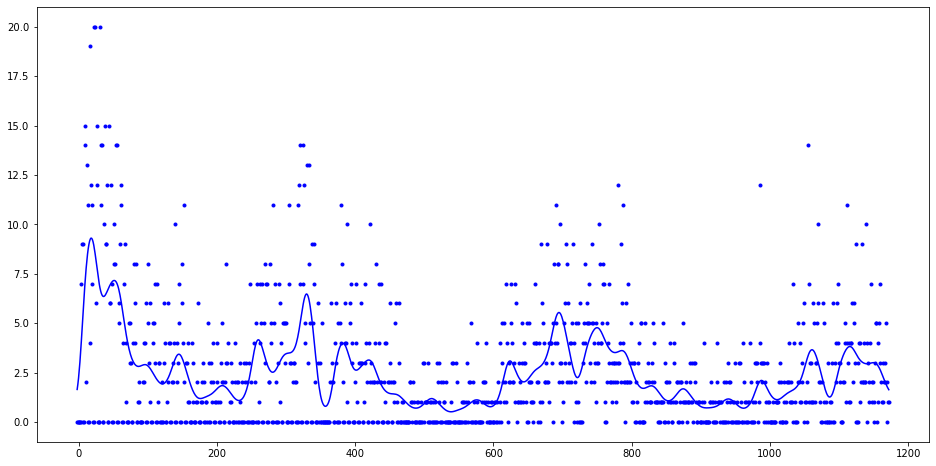

RMSE_bar =  0.0214882520868585
MMA= 0.8220094127628136


In [ ]:
argos.set_option('ts_ts')
argos.set_iter(80000)
argos.set_num_samples(20000)


rmae = []
rMMA_all = []
rMMB_all = []


for slice_ in slices:
    yw = slice_["yw"]
    yt = slice_["yt"]
    argos.set_data(sigma_mu1               = 10.0,
                   sigma_beta1             = 10.0,
                   sigma_psi1              = 0.1,
                   sigma_eta               = 0.002,
                   sigma_zeta              = 0.002,
                   sigma_kappa             = 0.09,
                   rho                     = 0.997,
                   To                      = 365,
                   seasonality_components  = 10, 
                   sigma                   = 5,
                   Tc                      = 365,
                   sigma_mu1_              = 10.0,
                   sigma_beta1_            = 10.0,
                   sigma_psi1_             = 0.9, 
                   sigma_eta_              = 0.001, #.001
                   sigma_zeta_             = 0.001, #.001
                   sigma_kappa_            = 0.09,  
                   rho_                    = 0.995,
                   To_                     = 365,
                   seasonality_components_ = 10,
                   sigma_                  = 5,
                   Tc_                     = 365,
                   chi_df                  = 10)
       
    stan_data       = argos.serialize(yw)
    stan_fit        = argos.fit(stan_model=stan_model_ts_ts)
    stan_parameters = argos.get_parameters(stan_fit)
    
    
    mu     = np.array(stan_parameters["mu"])
    X      = np.array(stan_data["X"])
    gammas = np.array(stan_parameters["gammas"])
    
    
    mu_     = np.array(stan_parameters["mu_"])
    X_      = np.array(stan_data["X_"])
    gammas_ = np.array(stan_parameters["gammas_"])
    trend_  = np.exp( mu_ + np.matmul(X_,gammas_))
    theta   = trend_/(1+trend_)
    
    trend   = np.exp( mu + np.matmul(X,gammas))
    
    y_bar   = (1-theta)* trend
    
    
    # Plot fit
    plt.figure(figsize=(16, 8))
    plt.plot(yw,'b.')
    sig = pd.Series(data=y_bar, index=yw.index)
    plt.plot(sig,'b')
    plt.show()
    

    RMSE_bar  = np.sqrt(np.mean(yw - y_bar)**2)
    print("RMSE_bar = ", RMSE_bar) 
    
    C  = np.mean(yw,axis=0)
    MMA = np.mean(np.abs(yw - y_bar))
    rMMA = MMA/np.mean(np.abs(yw - C))
    print("MMA=", rMMA)
    
    rMMA_all.append(rMMA)

    
    
    # Compute samples
    samples_data = argos.sample(yw, yt, stan_data, stan_parameters)
    
    st_all     = samples_data["st_all"]
    st_all_    = samples_data["st_all_"]    
    mae_all    = samples_data["mae_all"] 
    rmae_all   = samples_data["rmae_all"]     
    rmse_all   = samples_data["rmse_all"]
    y_hat_all  = samples_data["y_hat_all"]
    theta_all  = samples_data["theta_all"]
    phi        = samples_data["phi_all"]    
    
    
    print("RMSE = ", np.mean(np.mean(rmse_all,axis=0)))
    print("MAE = ",   np.mean(np.mean(mae_all,axis=0)))
    print("rMAE= ",   np.mean(np.mean(rmae_all,axis=0)))
    
    MMB = np.mean(np.abs(yt-my))
    rMMB = MMB/np.mean(np.abs(yt - C))
    print("MMB=", rMMB)
    rMMB_all.append(rMMB) 
    
        
    
    my = np.mean(y_hat_all,axis=0)
    stdy = np.std(y_hat_all,axis=0)
    
    plt.figure(figsize=(16, 8))
    plt.stem(yt.index, yt)
    sig = pd.Series(data=my, index=yt.index)
    plt.plot(sig)
    sig = pd.Series(data=my+stdy, index=yt.index)
    plt.plot(sig)
    sig = pd.Series(data=my+2*stdy, index=yt.index)
    plt.plot(sig)
    plt.show()
    

    plt.figure(figsize=(16, 8))
    plt.plot(yw,'.')
    tmp = np.exp( mu + np.matmul(X,gammas))
    sig = pd.Series(data=tmp, index=yw.index)
    plt.plot(sig)
    plt.show()
    
    mt = np.mean(theta_all,axis=0)
    plt.figure(figsize=(16, 8))
    sig = pd.Series(data=mt, index=yt.index)
    plt.plot(sig)
    plt.show()  
       
    print("Index:") 
    s3 = (yt - my - stdy )/(my+stdy) 
    sig = pd.Series(data=s3, index=yt.index)
    plt.stem(sig.index,sig)        
    plt.grid()
    plt.show()  
      
    plt.figure(figsize=(16, 8)) 
    markerline2, stemlines, _  = plt.stem(yt.index,yt)
    sig = pd.Series(data=my, index=yt.index)
    markerline1, stemlines, _  = plt.stem(sig.index,sig) 
    sig = pd.Series(data=my+stdy, index=yt.index)
    markerline3, stemlines, _  = plt.stem(sig.index,sig) 
        
    plt.setp(markerline2, 'markerfacecolor', 'r')
    plt.setp(markerline1, 'markerfacecolor', 'b') 
    plt.setp(markerline3, 'markerfacecolor', 'g')  
    plt.show()
                 
        
    y_hat_all_p = np.percentile(y_hat_all,q=[50,75,95],axis=0)   
    a = np.mean(samples_data["y_hat_all"],axis=0)
    b = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[0]
    c = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[1]
    d = np.mean(samples_data["y_hat_all"],axis=0) + y_hat_all_p[2]
    
    sig = pd.Series(data=b, index=yt.index)
    plt.plot(sig,color = '#0072B2')
    sig = pd.Series(data=c, index=yt.index)
    plt.plot(sig,color = '#0072B2')
    sig = pd.Series(data=d, index=yt.index)
    plt.plot(sig,color = '#0072B2')
    
    sig = pd.Series(data=a, index=yt.index)
    plt.plot(sig,'r')
    sig = pd.Series(data=a+stdy, index=yt.index)
    plt.plot(sig)    
    plt.stem(yt.index,yt)
    plt.fill_between(yt.index,b, c,color = '#0072B2', alpha=0.6)
    plt.fill_between(yt.index,c, d,color = '#0072B2', alpha=0.8)
    plt.show()
    
    
    # Plot all
    plt.figure(figsize=(16, 8))
    plt.plot(yw,'b.')
    sig = pd.Series(data=y_bar, index=yw.index)
    plt.plot(sig,'b')
    plt.plot(yt,'g.')
    sig = pd.Series(data=my, index=yt.index)
    plt.plot(sig,'g') 
     
    plt.show() 
    
    rmae.append(np.mean(np.mean(rmae_all,axis=0)))
      
print("rMAE=", np.mean(rmae)) 
print("rMMA=", np.mean(rMMA_all))
print("rMMB=", np.mean(rMMB_all))

opt_data = pd.read_csv("data/input/opt_data.csv")